In [14]:
import numpy as np
from pynwb import NWBHDF5IO, NWBFile
from scipy.stats import mode
import os
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
nwb_path = '../../data/Ghaderi/data_ephys/sub-PG019_ses-20200904T224847-processed-behavior.nwb'
io = NWBHDF5IO(nwb_path, 'r')
nwbfile = io.read()

c:\Users\tjnguyen\AppData\Local\anaconda3\envs\trial-matching\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\tjnguyen\AppData\Local\anaconda3\envs\trial-matching\lib\site-packages\hdmf\spec\namespace.py:58: UserWarning: Loaded namespace 'AIBS_ecephys' is missing the required key 'version'. Version will be set to 'None'. Please notify the extension author.
  warn(f"Loaded namespace '{name}' is missing the required key 'version'. Version will be set to "
c:\Users\tjnguyen\AppData\Local\anaconda3\envs\trial-matching\lib\site-packages\pynwb\file.py:146: UserWarning: Date is missing timezone information. Updating to local timezone.
  args_to_set['date_of_birth'] = _add_missing_timezone(date_of_birth)


In [16]:
nwbfile

Data type,object
Shape,"(2,)"
Array size,16.00 bytes
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,0.5
Data type,float64
Shape,"(47,)"
Array size,376.00 bytes
Chunk shape,None


In [4]:
str = nwbfile.session_id
str_splits = str.split('-')
sub_id = str_splits[1].split('_')[0]
time_id = str_splits[2].split('T')[0]

print(sub_id, time_id)

PG019 20200904


In [17]:
trial_df = nwbfile.trials.to_dataframe()
slice_df = trial_df[['context', 'whisker_stim', 'lick_flag', 'trial_type', 'early_lick']]
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(slice_df)

In [5]:
nwbfile.processing['behavior']['BehavioralTimeSeries']

Data type,float64
Shape,"(783657,)"
Array size,5.98 MiB
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,1.0
Data type,float64
Shape,"(783657,)"
Array size,5.98 MiB
Chunk shape,None


In [9]:
from scipy.stats import mode

jaw_coord = nwbfile.processing['behavior']['BehavioralTimeSeries']['Jaw_Coordinate']

In [8]:
mode(jaw_coord.data[:])

ModeResult(mode=array([[nan, nan]]), count=array([[7918, 7918]]))

In [ ]:
counts = np.sum(np.isnan(jaw_coord.data[:]), axis=0)
np.isnan(jaw_coord.data[counts[0]:])

True

In [20]:
jaw_coord.timestamps[:]

array([  23.615313,   23.625313,   23.635313, ..., 7864.697161,
       7864.707161, 7864.717161])

In [31]:
jaw_coord_trials = []
time = jaw_coord.timestamps[:]

trials = nwbfile.trials
for trial in trials:
    start_idx = np.argmin(np.abs(time - trial['start_time'].values[0]))
    stop_idx = np.argmin(np.abs(time - trial['stop_time'].values[0]))

    jaw_coord_trials.append(jaw_coord.data[start_idx:stop_idx])

jaw_coord_trials = np.array(jaw_coord_trials)

In [38]:
jaw_coord_trials.shape

(695, 200, 2)

In [41]:
np.isnan(jaw_coord_trials).sum(1)

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]])

In [54]:
for bp, trial in zip(np.isnan(jaw_coord_trials).sum(1), trials):
    if (bp.sum() > 0):
        print(bp)
        # print(trial)

[200 200]
[200 200]
[200 200]
[91 91]


In [55]:
jaw_coord_trials_x = jaw_coord_trials[:, :, 0].flatten()
jaw_coord_trials_y = jaw_coord_trials[:, :, 1].flatten()

jaw_coord_trials_x = jaw_coord_trials_x[~np.isnan(jaw_coord_trials_x)]
jaw_coord_trials_y = jaw_coord_trials_y[~np.isnan(jaw_coord_trials_y)]

closed_x_coord = mode(jaw_coord_trials_x)
closed_y_coord = mode(jaw_coord_trials_y)

print(closed_x_coord, closed_y_coord)

ModeResult(mode=array([132.09910583]), count=array([6])) ModeResult(mode=array([408.37908936]), count=array([7]))


In [56]:
jaw_coord_x = jaw_coord.data[:, 0]
jaw_coord_y = jaw_coord.data[:, 1]

jaw_coord_x = jaw_coord_x[~np.isnan(jaw_coord_x)]
jaw_coord_y = jaw_coord_y[~np.isnan(jaw_coord_y)]

test_x_coord = mode(jaw_coord_x)
test_y_coord = mode(jaw_coord_y)

print(test_x_coord, test_y_coord)

ModeResult(mode=array([132.02554321]), count=array([11])) ModeResult(mode=array([408.72079468]), count=array([20]))


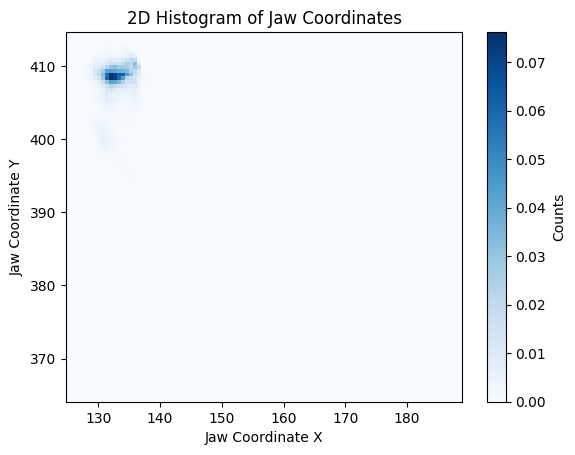

In [61]:
import matplotlib.pyplot as plt

plt.hist2d(jaw_coord_x, jaw_coord_y, bins=100, cmap='Blues', density=True)
plt.colorbar(label='Counts')
plt.xlabel('Jaw Coordinate X')
plt.ylabel('Jaw Coordinate Y')
plt.title('2D Histogram of Jaw Coordinates')
plt.show()

In [63]:
jaw_coord_x = jaw_coord.data[:, 0]
jaw_coord_y = jaw_coord.data[:, 1]

jaw_coord_x = jaw_coord_x[~np.isnan(jaw_coord_x)]
jaw_coord_y = jaw_coord_y[~np.isnan(jaw_coord_y)]

closed_x_coord = mode(jaw_coord_x)
closed_y_coord = mode(jaw_coord_y)

closed_coord = np.array([closed_x_coord[0][0], closed_y_coord[0][0]])

In [ ]:
jaw_trace = np.linalg.norm(jaw_coord_trials - closed_coord, axis=2)

array([[4.59517188, 6.50387818, 3.39495132, ..., 2.7638181 , 2.96084015,
        3.93727418],
       [2.3647552 , 2.06469589, 1.84963182, ..., 2.62671341, 2.51969944,
        2.45593248],
       [4.00945339, 3.7051227 , 4.8579068 , ..., 1.66113046, 0.72755492,
        1.3466729 ],
       ...,
       [3.81455889, 4.17098234, 2.7608116 , ..., 3.05513746, 3.12794737,
        3.1239698 ],
       [0.37462026, 1.26374881, 2.5807612 , ..., 3.12788503, 3.13320078,
        2.75276412],
       [2.71813558, 2.90631773, 2.38207407, ..., 5.25735733, 5.17156509,
        5.17316034]])

Text(0, 0.5, 'jaw displacement [U]')

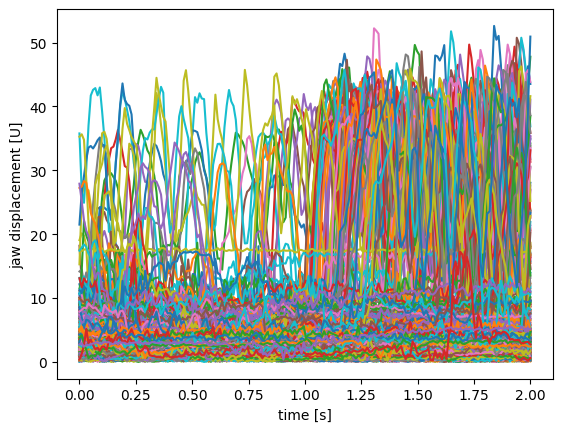

In [73]:
time = np.linspace(0, 2, jaw_trace.shape[1])
for trace in jaw_trace:
    plt.plot(time, trace)

plt.xlabel('time [s]')
plt.ylabel('jaw displacement [U]')

In [76]:
for trial in trials:
    if trial['early_lick'].values[0]:
        print(trial['trial_type'])

id
12    1.0
Name: trial_type, dtype: float64
id
15    2.0
Name: trial_type, dtype: float64
id
38    2.0
Name: trial_type, dtype: float64
id
39    2.0
Name: trial_type, dtype: float64
id
53    5.0
Name: trial_type, dtype: float64
id
84    1.0
Name: trial_type, dtype: float64
id
124    1.0
Name: trial_type, dtype: float64
id
142    3.0
Name: trial_type, dtype: float64
id
159    1.0
Name: trial_type, dtype: float64
id
184    2.0
Name: trial_type, dtype: float64
id
219    2.0
Name: trial_type, dtype: float64
id
220    2.0
Name: trial_type, dtype: float64
id
308    1.0
Name: trial_type, dtype: float64
id
318    4.0
Name: trial_type, dtype: float64
id
485    3.0
Name: trial_type, dtype: float64
id
486    3.0
Name: trial_type, dtype: float64
id
514    5.0
Name: trial_type, dtype: float64
id
551    3.0
Name: trial_type, dtype: float64
id
556    5.0
Name: trial_type, dtype: float64
id
609    1.0
Name: trial_type, dtype: float64
id
634    2.0
Name: trial_type, dtype: float64


In [89]:
np.unique(trials['context'][:])

array(['go_tone', 'no_tone', 'nogo_tone'], dtype=object)

In [90]:
np.unique(trials['auditory_stim_frequency'][:])

array([4000., 8000.,   nan])

In [11]:
io.close()

In [2]:
def save_datastructure(load_path="../../data/Ghaderi/data_ephys/", save_path="../datasets/data_parviz", save_behaviour=True, save_clusters_info=True):
    """ Transform NWB files into a folder structure easily accessible as a pytorch dataset
        Args:
            load_path (str): path to the folder containing the NWB files
            save_path (str): path to the folder where the dataset will be saved
            save_behaviour (bool): whether to save the behavioural data
            save_clusters_info (bool): whether to save the neuronal data
    """

    # create save directory
    if not os.path.exists(save_path):
        os.mkdir(save_path)

    # iterate through NWB directory
    nwb_files = [f for f in os.listdir(load_path) if f.endswith('.nwb')]
    for nwb_file in nwb_files:
        nwb_path = os.path.join(load_path, nwb_file)
        save_session(nwb_path, save_path, save_clusters_info)


def save_session(nwb_path, path, save_behaviour=True, save_clusters_info=True):
    """ Save session data into its own directory
        Args:
            nwb_path (str): path to the NWB file of the session
            path (str): path to the folder where the dataset is saved
            save_behaviour (bool): whether to save the behavioural data
            save_clusters_info (bool): whether to save the neuronal data
    """

    with NWBHDF5IO(nwb_path, 'r') as io:
        nwbfile = io.read()

        trial_df = pd.DataFrame(columns=("trial_number", "audio_cue", "audio_frequency", "whisker_stim", "trial_type", "early_lick", "trial_onset", "jaw_trace"))
        df_entry = pd.DataFrame(columns=trial_df.columns)

        # creating session directory
        session_id = nwbfile.session_id
        str_splits = session_id.split('-')
        sub_id = str_splits[1].split('_')[0]
        time_id = str_splits[2].split('T')[0]
        session_path = os.path.join(path, sub_id + "_" + time_id)
        if not os.path.exists(session_path):
            os.mkdir(session_path)
        
        # pre-process the jaw coordinates
        jaw_coord = nwbfile.processing['behavior']['BehavioralTimeSeries']['Jaw_Coordinate']
        jaw_coord_x = jaw_coord.data[:, 0]
        jaw_coord_y = jaw_coord.data[:, 1]
        jaw_time = jaw_coord.timestamps[:]

        jaw_coord_x = jaw_coord_x[~np.isnan(jaw_coord_x)]
        jaw_coord_y = jaw_coord_y[~np.isnan(jaw_coord_y)]

        closed_coord = np.array([mode(jaw_coord_x)[0][0], mode(jaw_coord_y)[0][0]])

        # fill the trial dataframe
        trials = nwbfile.trials
        for trial in trials:
            # trial information
            df_entry['trial_number'] = trial.index
            df_entry['audio_cue'] = trial['context'].values[0]
            df_entry['audio_frequency'] = trial['auditory_stim_frequency'].values[0]
            df_entry['whisker_stim'] = trial['whisker_stim'].values[0]
            df_entry['trial_type'] = trial['trial_type'].values[0]
            df_entry['early_lick'] = trial['early_lick'].values[0]
            df_entry['trial_onset'] = trial['start_time'].values[0]

            # store behavioural data as npy
            start_idx = np.argmin(np.abs(jaw_time - trial['start_time'].values[0]))
            stop_idx = np.argmin(np.abs(jaw_time - trial['stop_time'].values[0]))

            jaw_trace = np.linalg.norm(jaw_coord.data[start_idx:stop_idx] - closed_coord, axis=1)

            if not os.path.exists(os.path.join(session_path, "jaw_trace")):
                os.mkdir(os.path.join(session_path, "jaw_trace"))
            jaw_path = os.path.join(session_path, "jaw_trace", "trial_{}".format(trial.index[0]))
            if save_behaviour:
                np.save(jaw_path, jaw_trace)
            
            df_entry['jaw_trace'] = jaw_path

            # add entry to trial_df
            trial_df = pd.concat([trial_df, df_entry], ignore_index=True)
        
        trial_df = trial_df.fillna(0)
        trial_df.to_csv(os.path.join(session_path, "trial_info"))
        if save_clusters_info:
            save_clusters(nwbfile, session_path)
    
def save_clusters(nwbfile, session_path):
    """Save the neuronal data into the session directory
        Args:
            nwbfile (NWBFile): NWB file object
            session_path (str): path to the session directory
    """

    cluster_df = pd.DataFrame(columns=("neuron_index", "area", "excitatory", "depth", "cluster", "firing_rate"))
    df_entry = pd.DataFrame(columns=cluster_df.columns)

    for neuron in nwbfile.units:
        if (not neuron['rsUnits'].values[0] and not neuron['fsUnits'].values[0]): # ignore non-excitatory/inhibitory unit
            continue
        excitatory = neuron['rsUnits'].values[0]
        df_entry['neuron_index'] = neuron.index
        df_entry['excitatory'] = [excitatory]
        df_entry['area'] = neuron['location'].values[0]
        df_entry['depth'] = neuron['allenccf_area_layer'].values[0]
        df_entry['cluster'] = neuron['cluster_id'].values[0]
        df_entry['firing_rate'] = neuron['firing_rate'].values[0]

        spikes = neuron['spike_times'].values[:]
        np.save(os.path.join(session_path, "neuron_index_{}".format(neuron.index[0])), spikes)

        cluster_df = pd.concat([cluster_df, df_entry], ignore_index=True)
    cluster_df.to_csv(os.path.join(session_path, "cluster_info"))

In [3]:
save_datastructure()

c:\Users\tjnguyen\AppData\Local\anaconda3\envs\trial-matching\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\tjnguyen\AppData\Local\anaconda3\envs\trial-matching\lib\site-packages\hdmf\spec\namespace.py:58: UserWarning: Loaded namespace 'AIBS_ecephys' is missing the required key 'version'. Version will be set to 'None'. Please notify the extension author.
  warn(f"Loaded namespace '{name}' is missing the required key 'version'. Version will be set to "
c:\Users\tjnguyen\AppData\Local\anaconda3\envs\trial-matching\lib\site-packages\pynwb\file.py:146: UserWarning: Date is missing timezone information. Updating to local timezone.
  args_to_set['date_of_birth'] = _add_missing_timezone(date_of_birth)
c:\Users\tjnguyen\AppData\Local\anaconda3\envs\trial-matching\lib\site-packages\hdmf\spec\n

In [4]:
def unified_cluster_table(path="../datasets/data_parviz"):
    """Consolidate the cluster information of all sessions into a single csv file.
        Args:
            path (str, optional): path to the folder containing the session directories.
    """

    cluster_information = pd.DataFrame(columns=("session", "area", "excitatory", "firing_rate", "cluster_index"))
    dirs = os.listdir(path)
    if "cluster_information" in dirs:
        dirs.remove("cluster_information")
    df_entry = {}
    for dir in dirs:
        try:
            df = pd.read_csv(os.path.join(path, dir, "cluster_info"))
        except:
            pass
        df_entry = pd.DataFrame(columns=cluster_information.columns)
        df_entry["session"] = [dir]
        df.neuron_index = df.index.values
        df.to_csv(os.path.join(path, dir, "cluster_info"))
        for index, row in df.iterrows():
            df_entry["area"] = [row.area]
            df_entry["excitatory"] = [row.excitatory]
            df_entry["firing_rate"] = [row.firing_rate]
            df_entry["cluster_index"] = [index]
            cluster_information = pd.concat([cluster_information, df_entry], ignore_index=True)
    cluster_information.to_csv(os.path.join(path, "cluster_information"))

In [5]:
unified_cluster_table()